In [176]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, LSTM, Dense, Bidirectional
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import MinMaxScaler
InteractiveShell.ast_node_interactivity = "all"

# ARIMA
import pmdarima as pm

%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

<h4>Importing Datasets</h4>

In [177]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [178]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [179]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [180]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [181]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [182]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [183]:
# Accessing the highest count in the each keypouch, new and old.
sel_country = old_df[1]
print(sel_country)

sel_df = filtered_dataframe1[sel_country]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[sel_country]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()

Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600140,CTNR010050700496,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200.0
1,ECS01050600140,CTNR010050700495,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200.0
2,ECS010050700037,CTNR010050700657,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-21,40,HC,2300.0
3,ECS01050600141,CTNR010050700808,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-26,40,HC,2200.0
4,ECS01050600042,CTNR010050700971,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-29,40,HC,2600.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1683,ECS010230100188,010000371218,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-09,40,HC,1500.0
1684,ECS010230100390,010000377561,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-14,40,HC,1500.0
1685,ECS010230100390,010000371211,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-14,40,HC,1500.0
1686,ECS010230100462,010000390201,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-21,40,HC,1500.0
1687,ECS010230100462,010000377408,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-21,40,HC,1500.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 0 to 1687
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1688 non-null   object        
 1   CNTR_ID     1688 non-null   object        
 2   POD_ID      1688 non-null   object        
 3   ETD_POL_D   1688 non-null   object        
 4   PARTY_ID    1688 non-null   object        
 5   PARTY_NAME  1688 non-null   object        
 6   POD         1688 non-null   datetime64[ns]
 7   CNTR_SIZE   1688 non-null   object        
 8   CNTR_TYPE   1688 non-null   object        
 9   RATE        1688 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 145.1+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600140,CTNR010050700496,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200.0
1,ECS01050600140,CTNR010050700495,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200.0
2,ECS010050700037,CTNR010050700657,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-21,40,HC,2300.0
3,ECS01050600141,CTNR010050700808,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-26,40,HC,2200.0
4,ECS01050600042,CTNR010050700971,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-29,40,HC,2600.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1699,ECS010230200029,010000495920,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-04-23,40,HC,664.0
1700,ECS010230400101,010000535699,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-02,40,HC,350.0
1701,ECS010230300066,010000515298,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-02,40,HC,264.0
1702,ECS010230300067,010000550266,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-08,40,HC,264.0
1703,ECS010230300067,010000535541,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-08,40,HC,264.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704 entries, 0 to 1703
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1704 non-null   object        
 1   CNTR_ID     1704 non-null   object        
 2   POD_ID      1704 non-null   object        
 3   ETD_POL_D   1704 non-null   object        
 4   PARTY_ID    1704 non-null   object        
 5   PARTY_NAME  1704 non-null   object        
 6   POD         1704 non-null   datetime64[ns]
 7   CNTR_SIZE   1704 non-null   object        
 8   CNTR_TYPE   1704 non-null   object        
 9   RATE        1704 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 146.4+ KB


<h2>Data Preprocessing</h2>

<h4>Interpolate missing values in between dates</h4>

In [184]:
# Select features
sel_feat = ['POD','RATE']
robust_df = sel_df[sel_feat].copy()  # make a copy to avoid SettingWithCopyWarning

In [185]:
# Remove duplicated dates and cost rows
robust_df = robust_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=robust_df['POD'].min(), end=robust_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, robust_df, on='POD', how='left')  

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='polynomial', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(3)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()

,POD,RATE
0,2005-07-19,2200.0
1,2005-07-20,2250.0
2,2005-07-21,2300.0
3,2005-07-22,2280.0
4,2005-07-23,2260.0


,POD,RATE
6447,2023-02-17,1500.0
6448,2023-02-18,1500.0
6449,2023-02-19,1500.0
6450,2023-02-20,1500.0
6451,2023-02-21,1500.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6452 entries, 0 to 6451
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6452 non-null   datetime64[ns]
 1   RATE    6452 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 151.2 KB


<h4>Grouping it to week</h4>

In [186]:
from scipy import stats

# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated, on=['YearMonthWeek'], how='left')

# Now you can group by YearMonthWeek and compute your rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate trimmed mean of RATE values
    rate_metric = stats.trim_mean(group_df['RATE'].dropna().values, 0.1) # trimming 10% from each end

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)
agg_df['Rate'] = agg_df['Rate'].round(2)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_19852\679132877.py:21: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_19852\679132877.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_19852\679132877.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_19852\679132877.py:41: FutureWarning: The frame.append method is deprecated and will be remov

,YearMonthWeek,Rate
0,2005-07-18,2255.00
1,2005-07-25,2388.57
2,2005-08-01,2261.43
3,2005-08-08,2202.86
4,2005-08-15,2253.57
5,2005-08-22,2252.14
6,2005-08-29,2252.45
7,2005-09-05,2220.41
8,2005-09-12,2200.00
9,2005-09-19,2200.00


,YearMonthWeek,Rate
903,2022-11-07,5145.71
904,2022-11-14,5877.27
905,2022-11-21,5404.55
906,2022-11-28,4232.47
907,2022-12-05,3433.33
908,2022-12-12,3672.92
909,2022-12-19,4011.90
910,2022-12-26,4164.29
911,2023-01-02,3007.14
912,2023-01-09,2687.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  918 non-null    datetime64[ns]
 1   Rate           918 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.5 KB


<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [187]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200255,010000421246,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-03-10,40,HC,1100.0
1,ECS010230200255,010000410650,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-03-10,40,HC,1100.0
2,ECS010230100273,010000423692,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-03-14,40,HC,986.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
13,ECS010230300066,010000515298,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-02,40,HC,264.0
14,ECS010230300067,010000550266,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-08,40,HC,264.0
15,ECS010230300067,010000535541,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-08,40,HC,264.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      16 non-null     object        
 1   CNTR_ID     16 non-null     object        
 2   POD_ID      16 non-null     object        
 3   ETD_POL_D   16 non-null     object        
 4   PARTY_ID    16 non-null     object        
 5   PARTY_NAME  16 non-null     object        
 6   POD         16 non-null     datetime64[ns]
 7   CNTR_SIZE   16 non-null     object        
 8   CNTR_TYPE   16 non-null     object        
 9   RATE        16 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.4+ KB


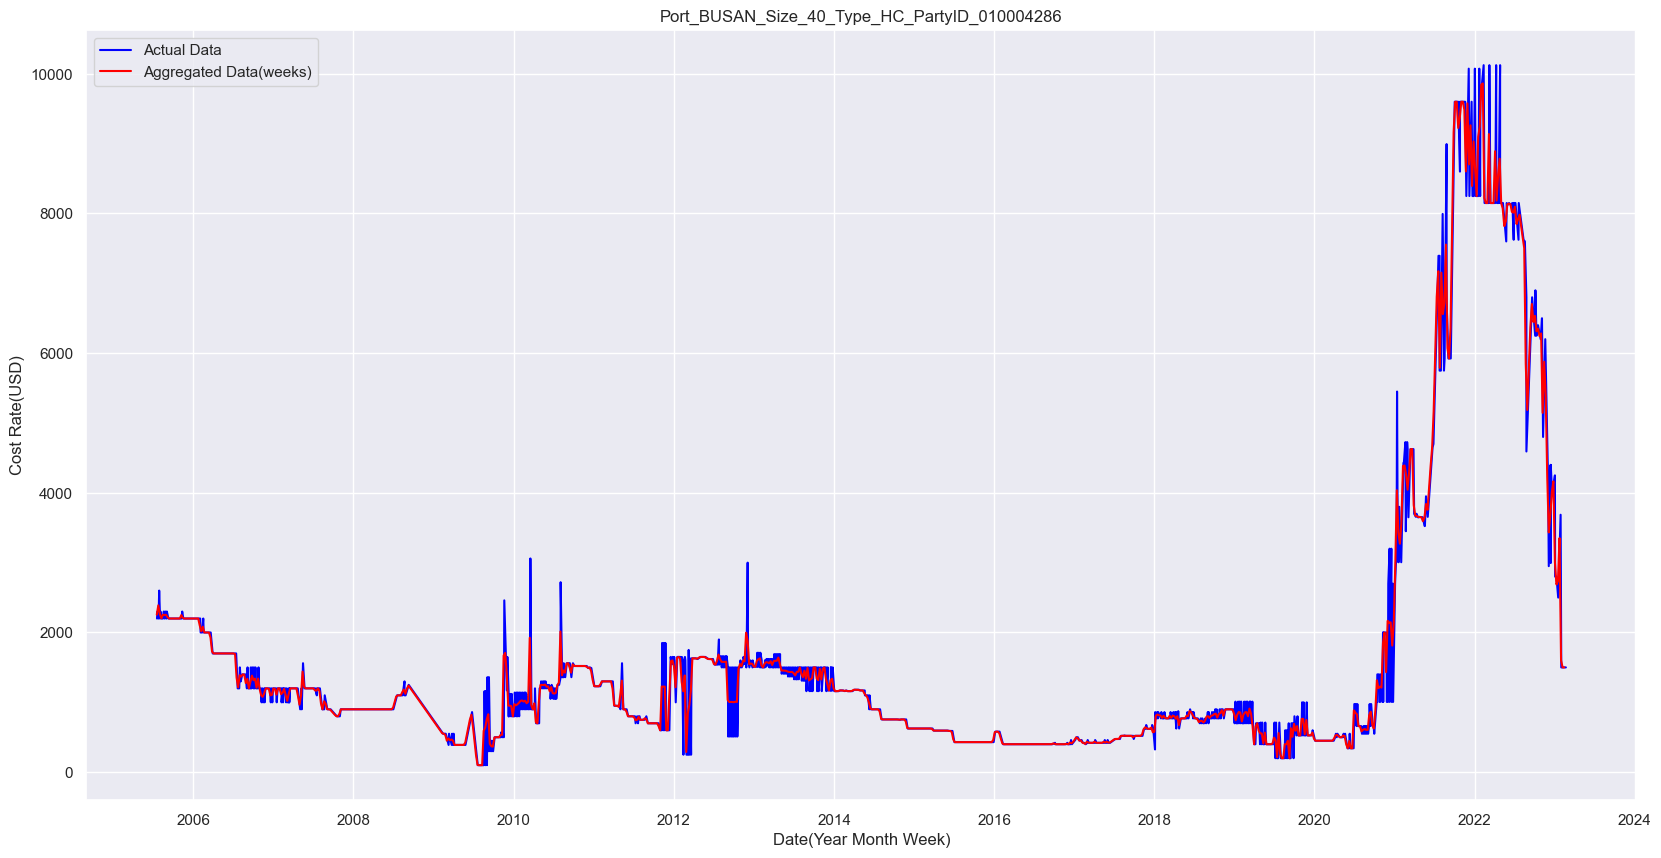

In [188]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();

In [189]:
df = agg_df[['YearMonthWeek','Rate']].copy()
df.set_index('YearMonthWeek', inplace=True)
df.head()
df.info()

,Rate
YearMonthWeek,
2005-07-18,2255.00
2005-07-25,2388.57
2005-08-01,2261.43
2005-08-08,2202.86
2005-08-15,2253.57


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 918 entries, 2005-07-18 to 2023-02-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rate    918 non-null    float64
dtypes: float64(1)
memory usage: 14.3 KB


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Rate over time')

Text(0.5, 0, 'YearMonthWeek')

Text(0, 0.5, 'Rate')

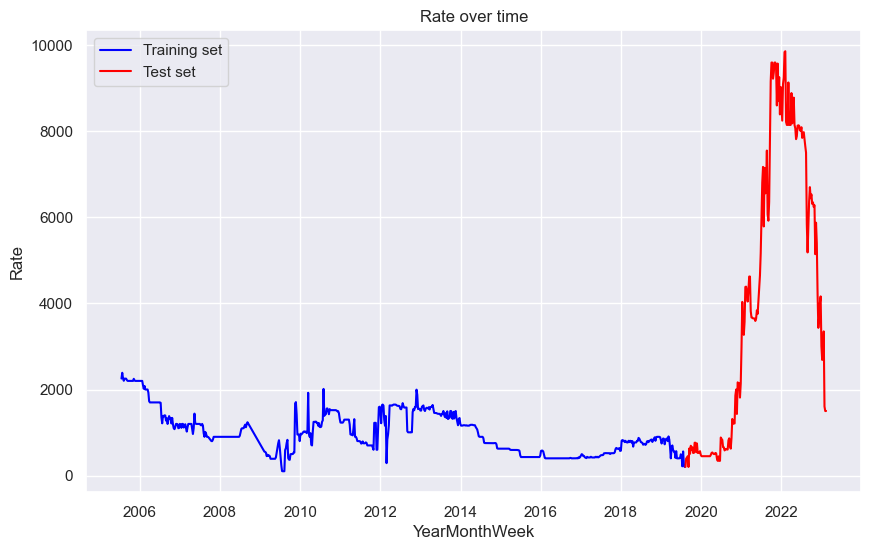

In [190]:
# Splitting into training and test sets
train_size = int(len(df) * 0.8)  # 80% of data as training
df_train = df[:train_size]
df_valid = df[train_size:]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train['Rate'], color='blue', label='Training set')
plt.plot(df_valid.index, df_valid['Rate'], color='red', label='Test set')
plt.title('Rate over time')
plt.xlabel('YearMonthWeek')
plt.ylabel('Rate')
plt.legend()
plt.show()


In [191]:
# Rolling mean for 3 weeks and shift of 1 to avoid lookahead bias
df_train['Rate_rolled_3w'] = df_train['Rate'].rolling(window=3, min_periods=0).mean().shift(1)
df_valid['Rate_rolled_3w'] = df_valid['Rate'].rolling(window=3, min_periods=0).mean().shift(1)

# Creating temporal features for train and valid sets
for df_ in [df_train, df_valid]:
    df_['Covid'] = 0
    df_.loc[(df_.index >= '2020-01') & (df_.index <= '2023-01'), 'Covid'] = 1
    
    df['Year'] = df['POD'].dt.year
    df['Month'] = df['POD'].dt.month
    df['Quarter'] = df['POD'].dt.quarter

    # Creating lag features
    for i in range(1, 4):
        df_[f'Rate_lag_{i}'] = df_['Rate'].shift(i)

    # Creating rolling mean and std features
    df_['Rate_mean_rolled_3w'] = df_['Rate'].rolling(window=3).mean().shift(1)
    df_['Rate_std_rolled_3w'] = df_['Rate'].rolling(window=3).std().shift(1)

exogenous_features = ['Rate_rolled_3w', 'Covid', 
                      'Rate_lag_1', 'Rate_lag_2', 'Rate_lag_3',
                      'Rate_mean_rolled_3w', 'Rate_std_rolled_3w']


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_19852\3078166671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Rate_rolled_3w'] = df_train['Rate'].rolling(window=3, min_periods=0).mean().shift(1)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_19852\3078166671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Rate_rolled_3w'] = df_valid['Rate'].rolling(window=3, min_periods=0).mean().shift(1)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_19852\3078166671.py:7: Setti

In [192]:
# Training the model with exogenous features from the training set
model = pm.auto_arima(df_train["Rate"],
                      exogenous=df_train[exogenous_features],
                      trace=True,
                      error_action="ignore",
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9150.005, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9195.947, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9181.729, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9176.319, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9194.299, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9148.066, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9160.698, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9146.503, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9173.876, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9146.085, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9174.863, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9180.205, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=9147.568, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_19852\2618848451.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_ARIMA"] = preds


,Rate,Rate_rolled_3w,Covid,Rate_lag_1,Rate_lag_2,Rate_lag_3,Rate_mean_rolled_3w,Rate_std_rolled_3w,Forecast_ARIMA
YearMonthWeek,,,,,,,,,
2019-08-12,200.0,NaN,0,NaN,NaN,NaN,NaN,NaN,246.650811
2019-08-19,400.0,200.000000,0,200.0,NaN,NaN,NaN,NaN,274.012437
2019-08-26,400.0,300.000000,0,400.0,200.0,NaN,NaN,NaN,290.060574
2019-09-02,450.0,333.333333,0,400.0,400.0,200.0,333.333333,115.470054,299.473125
2019-09-09,200.0,416.666667,0,450.0,400.0,400.0,416.666667,28.867513,304.993773


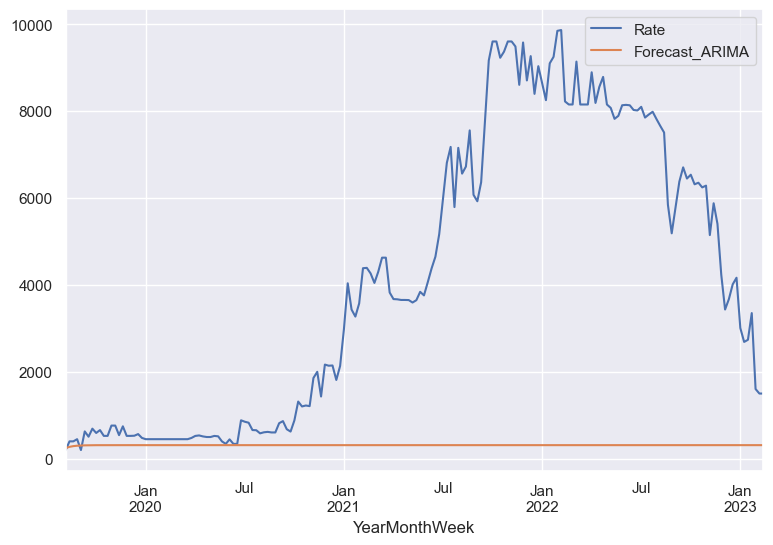

In [201]:
# Predicting on the validation set
preds = model.predict(n_periods=len(df_valid),  exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMA"] = preds

df_valid.head()

# Plotting the validation set
ax = df_valid[["Rate", "Forecast_ARIMA"]].plot(figsize=(9, 6))
ax.grid("both")
plt.show()

In [194]:
# # General Functions

# # Mean Square Error Function:
# def calculate_RMSE(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))


# def plot_train_val_loss(history):
#     plt.figure(figsize=(10, 6))
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title('Model loss progress during training and validation')
#     plt.xlabel('Epoch')
#     plt.ylabel('Training and Validation Loss')
#     plt.legend()
#     plt.show()


<h4>Arima</h4>

In [195]:
# # Function to execute Auto ARIMA model

# # Fit an auto_arima model
# arima_model = pm.auto_arima(train, start_p=1, start_q=1,
#                             max_p=5, max_q=5, m=12,
#                             start_P=0, seasonal=False,
#                             d=0, D=0, trace=True,
#                             error_action='ignore',
#                             suppress_warnings=True,
#                             stepwise=True)  # set to stepwise

# # Print the summary of the model
# print(arima_model.summary())

# # Forecast
# train_forecast = arima_model.predict_in_sample()
# test_forecast = arima_model.predict(n_periods=len(test))

# # Calculate the RMSE
# RMSE_ARIMA_train = np.sqrt(mean_squared_error(train, train_forecast))
# print("Train RMSE: %.3f" % RMSE_ARIMA_train)
# RMSE_ARIMA_test = np.sqrt(mean_squared_error(test, test_forecast))
# print("Test RMSE: %.3f" % RMSE_ARIMA_test)

# return arima_model, RMSE_ARIMA_train, RMSE_ARIMA_test

In [196]:
# # Normalize dataset for LSTM
# scaler = MinMaxScaler(feature_range=(0, 1))

# # Fit and transform the train dataset
# train_size = int(len(agg_df) * 0.7)
# train_data = agg_df['Rate'].values[:train_size].reshape(-1, 1)
# test_data = agg_df['Rate'].values[train_size:].reshape(-1, 1)
# train = scaler.fit_transform(train_data)

# # Only transform the test dataset
# test = scaler.transform(test_data)

# # Initialize a dictionary for the current key
# results_dict = {}

# print(f"Key: {sel_country}")

# # Run ARIMA model
# model, ARIMA_train_rmse, ARIMA_test_rmse = ARIMA_Execute(train_data, test_data)
# results_dict[sel_country]['ARIMA'] = {'model': model, 'Train RMSE': ARIMA_train_rmse, 'Test RMSE': ARIMA_test_rmse}

# # Now you can directly fetch your results using sel_country as the key
# results = results_dict[sel_country]
# best_model_name, best_model_results = min(results.items(), key=lambda x: x[1]['Test RMSE'])
# print(f"Key: {sel_country}, Best Model: {best_model_name}, Train RMSE: {best_model_results['Train RMSE']}, Test RMSE: {best_model_results['Test RMSE']}")


<h2>Forecasting with best model</h2>

In [197]:
# # Add check for 'RATE_actual' values to avoid division by zero
# # Accuracy
# def compute_accuracy(row):
#     if row['RATE_actual'] == 0:
#         return np.nan
#     else:
#         error = abs(row['RATE_actual'] - row['RATE_forecasted'])
#         error_proportion = error / row['RATE_actual']
#         return (1 - error_proportion) * 100

# # LSTM
# def forecast_next_weeks(model, look_back, scaler, last_values, n_weeks):
#     forecast = []
#     for _ in range(n_weeks):
#         # Reshape last_values to 2D array with one feature
#         last_values_2d = np.array(last_values[-look_back:]).reshape(-1, 1)

#         # Scale the last_values_2d to be between 0 and 1
#         input_values_scaled = scaler.transform(last_values_2d)

#         # Reshape input to be [samples, time steps, features]
#         input_values_scaled = input_values_scaled.reshape((1, look_back, 1))

#         # Predict the next value
#         prediction = model.predict(input_values_scaled)

#         # Rescale the prediction back to the original scale
#         prediction_rescaled = scaler.inverse_transform(prediction)

#         # Append the predicted value to the forecast list
#         forecast.append(prediction_rescaled[0][0])

#         # Append the predicted value to the last_values list to be used as input for the next prediction
#         last_values.append(prediction_rescaled[0][0])
#         # Drop the first value in the last_values list
#         last_values.pop(0)

#     return forecast



<h4>Comparing with actual updated against forecasted</h4>

In [198]:
# comparison_df = pd.DataFrame(columns=['WeekStart', 'WeekEnd', 'POD_actual', 'RATE_forecasted', 'RATE_actual'])
# df_forecasted['WeekEnd'] = df_forecasted['POD'] + pd.to_timedelta(7, unit='d')  

# for _, row in df_forecasted.iterrows():
#     mask = (new_dates_df['POD'] >= row['POD']) & (new_dates_df['POD'] < row['WeekEnd'])
#     actual_dates_within_week = new_dates_df[mask]

#     for _, actual_row in actual_dates_within_week.iterrows():
#         comparison_df = comparison_df.append({
#             'WeekStart': row['POD'],
#             'WeekEnd': row['WeekEnd'],
#             'POD_actual': actual_row['POD'],
#             'RATE_forecasted': row['RATE'],
#             'RATE_actual': actual_row['RATE']
#         }, ignore_index=True)

# # Remove duplicates
# comparison_df = comparison_df.drop_duplicates(subset=['POD_actual', 'RATE_forecasted', 'RATE_actual']).reset_index(drop=True)

# # Compute accuracy
# comparison_df['accuracy'] = comparison_df.apply(compute_accuracy, axis=1)
# comparison_df = comparison_df.dropna(subset=['accuracy'])

# total_mean_accuracy = comparison_df['accuracy'].mean()
# comparison_df
# print(f'The mean accuracy is {total_mean_accuracy:.2f}%\n')

<h4>Visualise all, Conclusion</h4>

In [199]:
# plt.figure(figsize=(20, 10))
# plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
# plt.plot(new_dates_df['POD'], new_dates_df['RATE'], color='blue', label="Actual Data (Updated)")

# plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='green', label="Aggregated Data")
# plt.plot(df_forecasted['POD'], df_forecasted['RATE'], color='red', label="Forecasted Data")

# plt.xlabel('Date(Year Month)')
# plt.ylabel('Cost Rate(USD)')
# plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
# plt.legend()
# plt.show();